In [13]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

In [14]:
class Vehicle:
    _id_counter = 0
    """Define vehicle attributes and rules to be implemented"""
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob, passenger_capacity):
        self.vehicle_id = Vehicle._id_counter  # Assign a unique ID to each vehicle
        Vehicle._id_counter += 1  # Increment the counter for the next vehicle
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_row = current_row #also known as the y position of the right side of the vehicle
        self.lane_changing_prob = lane_changing_prob #probability that a vehicle will transfer lane
        self.passenger_capacity = passenger_capacity
        self.occupied_seats = 10
        self.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(self.occupied_seats)]
        self.unoccupied_seats = self.passenger_capacity - self.occupied_seats
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def lane_changing(self, gap_distance):
        """attempts to change lanes based on vehicle type and lane availability
        Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide, with 1 cell wide passenger holding area beside row 0).
        We assume that each half lane is an array, imagine a vertical stack of arrays, indexing is from top to bottom (0-4). Right side is the bottom."""
        new_row = self.current_row
        if self.speed > gap_distance:
            if self.current_row == 0:
                new_row = self.current_row + 2
            elif self.current_row == 2:
                new_row = self.current_row - 2
        #Check for space on the lane of interest
        if self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width].sum() == 0:
            self.current_row = new_row

    def decelerate(self, gap_distance):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        if self.speed > gap_distance:
            self.speed = gap_distance

    def braking(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1

    def move(self):
        """implements movement"""
        next_position = (self.x_position + self.speed) % self.road_designation.road_length
        if self.road_designation.road_occupancy[next_position:next_position + self.length, self.current_row:self.current_row + self.width].sum() == 0:
            self.x_position = next_position

    def pick_up_passengers(self, passengers_at_sidewalk):
        """When jeep position on lane 0 is adjacent to an occupied position on the sidewalk, jeepney stops, then picks up all the passengers that it can pick up"""
        for passenger in passengers_at_sidewalk:
            if self.unoccupied_seats > 0:
                #print(f"Picking up passenger at position {passenger.location}")
                passenger.on_vehicle = True
                self.passengers.append(passenger)
                self.occupied_seats += 1
                self.unoccupied_seats -= 1
                #print(f"Vehicle now has {self.occupied_seats} occupied seats and {self.unoccupied_seats} unoccupied seats")

    def reset_occupancy(self):
        """This method resets occupancy when the vehicle reaches the end"""
        self.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(self.occupied_seats)]
        self.unoccupied_seats = self.passenger_capacity - self.occupied_seats


    def __vehiclerepr__(self):
        """String representation of the vehicle - for debugging"""
        return f"Vehicle(ID={self.vehicle_id}, type={self.vehicle_type}, position={self.x_position}, speed={self.speed}, occupied_seats={self.occupied_seats})"

In [15]:
class Passenger:
    def __init__(self, location, initially_on_vehicle=False):
        self.location = location # sets initial location
        self.waiting_time = 0
        self.travel_time = 0
        self.on_vehicle = False #whether the passenger is on the vehicle or not
        self.initially_on_vehicle = False #whether the passenger is already on the vehicle or not

    def increment_waiting_time(self):
        """increments the waiting_time by 1 if the passenger is not on the vehicle."""
        if not self.on_vehicle:
            self.waiting_time += 1

    def increment_travel_time(self):
        """increments the travel time by 1 if the passenger is on the vehicle."""
        if self.on_vehicle:
            self.travel_time += 1

    def __repr__(self):
        """String representation of the passenger - for debugging """
        #return f"Passenger(waiting_time={self.waiting_time}, travel_time={self.travel_time}, initially_on_vehicle={self.initially_on_vehicle})"

In [16]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [18]:
class Sidewalk:
    def __init__(self, sidewalk_length, passenger_spots_per_cell):
        self.sidewalk_length = sidewalk_length
        self.sidewalk_width = 1
        self.passenger_spots = passenger_spots_per_cell
        #initialize the sidewalk occupancy as a matrix of matrices
        self.sidewalk_occupancy = np.array([[np.full(passenger_spots_per_cell, None) for _ in range(self.sidewalk_width)] for _ in range(sidewalk_length)])
        
    def __repr__(self):
        return f"Sidewalk(occupancy={self.sidewalk_occupancy})"

In [19]:
class IntraRoadSimulator:
    def __init__(self, road):
        self.road = road  # Store the road instance
        self.vehicles = []  # List to store vehicle instances
        self.passengers = []  # List to store passenger instances
        self.sidewalk = Sidewalk(road.road_length, passenger_spots_per_cell = 10)
        self.occupancy_history = []  # List to store the history of road occupancy states
        self.passenger_throughput = 0  # Counter for the number of passengers transported
        self.vehicle_throughput = 0
        self.slowdown_counts = 0  # Counter for the number of slowdowns due to traffic

    def update_occupancy(self):
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length
            y_start = vehicle.current_row
            y_end = vehicle.current_row + vehicle.width
            if x_start < x_end:
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
            else:
                self.road.road_occupancy[x_start:, y_start:y_end] = 1
                self.road.road_occupancy[:x_end, y_start:y_end] = 1
        self.occupancy_history.append(self.road.road_occupancy.copy())

    def initialize_vehicles(self, density, truck_fraction, truck_lane_change_prob, jeep_lane_change_prob):
        A, B = 7 * 2, 3 * 2  # Constants for truck and jeep area
        L, W = self.road.road_length, self.road.road_width  # Road dimensions
        N = int(density * L * W * (truck_fraction / A + (1 - truck_fraction) / B))  # Number of vehicles based on density and truck fraction
        for _ in range(N):
            vehicle_type = 'truck' if np.random.rand() < truck_fraction else 'jeep'  # Randomly decide vehicle type
            length = 7 if vehicle_type == 'truck' else 3
            width = 2
            x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = np.random.randint(1, self.road.speed_limit + 1)
            passenger_capacity = 20 if vehicle_type == 'jeep' else 0
            lane_changing_prob = truck_lane_change_prob if vehicle_type == 'truck' else jeep_lane_change_prob
            current_row = 2 if vehicle_type == 'truck' else 0
            if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0:
                new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob, passenger_capacity)
                self.vehicles.append(new_vehicle)  # Add vehicle to the list
                self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 1  # Mark vehicle position on road occupancy grid

    def gap_distance(self, vehicle, vehicle_row_to_be_checked):
        current_x_position = vehicle.x_position
        max_distance = min(vehicle.speed, self.road.road_length - current_x_position - vehicle.length)  # Maximum possible gap distance
        
        gap_distance_row_1 = max_distance
        gap_distance_row_2 = max_distance
        
        for distance in range(1, max_distance + 1):
            next_x_position = (current_x_position + vehicle.length + distance) % self.road.road_length
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle_row_to_be_checked] == 1:
                gap_distance_row_1 = distance - 1  # Calculate gap distance in current lane
                break
        for distance in range(1, max_distance + 1):
            next_x_position = (current_x_position + vehicle.length + distance) % self.road.road_length
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle_row_to_be_checked + 1] == 1:
                gap_distance_row_2 = distance - 1  # Calculate gap distance in adjacent lane
                break
        return min(gap_distance_row_1, gap_distance_row_2)  # Return the minimum gap distance

    def passenger_headway(self, vehicle): 
        """This algorithm returns the distance to the nearest passenger"""
        current_x_position = vehicle.x_position
        max_distance = self.road.road_length - 2  # Maximum possible distance of passenger presence (road_length-1 is the toll)
        sidewalk = self.sidewalk
        nearest_passenger_distance = max_distance
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if any(self.sidewalk.sidewalk_occupancy[next_x_position, 0]):
                nearest_passenger_distance = distance
                break
        return nearest_passenger_distance  # Return the distance to the nearest passenger

    def passenger_arrival(self, arrival_rate):
        for x in range(self.road.road_length):
            if np.random.rand() < arrival_rate:  # Determine if a passenger arrives at this location
                for i in range(self.sidewalk.passenger_spots):
                    if self.sidewalk.sidewalk_occupancy[x][0][i] is None:  # Find an empty spot on the sidewalk
                        new_passenger = Passenger(location=(x, 0))
                        self.sidewalk.sidewalk_occupancy[x][0][i] = new_passenger  # Place the new passenger on the sidewalk
                        self.passengers.append(new_passenger)  # Add the new passenger to the list
                        break
                        
    def record_throughput(self, vehicle):
        num_passengers_on_board = sum(1 for passenger in vehicle.passengers)  # Record only passengers who are on the vehicle
        #print(f"Recording throughput for Vehicle {vehicle.vehicle_id} with {num_passengers_on_board} passengers")
        self.passenger_throughput += num_passengers_on_board
        self.vehicle_throughput += 1
    
    def reset_vehicle(self, vehicle):
        #clear the vehicle
        for passenger in vehicle.passengers:
            passenger.on_vehicle = False  # Set passengers to not on vehicle
        vehicle.passengers = []  # Clear passengers list
        #vehicle.occupied_seats = 0
        #vehicle.unoccupied_seats = vehicle.passenger_capacity

        #reload the vehicle with passengers
        vehicle.occupied_seats = 10
        vehicle.passengers = [Passenger(None, initially_on_vehicle=True) for _ in range(vehicle.occupied_seats)]  # Reset passengers
        vehicle.unoccupied_seats = vehicle.passenger_capacity - vehicle.occupied_seats  # Reset unoccupied seats
        #print(f"Resetting vehicle {vehicle.vehicle_id} with {vehicle.occupied_seats} passengers")
        
         # Move the vehicle to the start if space is available
        if self.road.road_occupancy[0:vehicle.length, vehicle.current_row:vehicle.current_row + vehicle.width].sum() == 0:
            vehicle.x_position = 0  # Wrap around to the start
            self.road.road_occupancy[0:vehicle.length, vehicle.current_row:vehicle.current_row + vehicle.width] = 1

    def simulation_step(self, density, truck_fraction, arrival_rate, a_dec):
        self.passenger_arrival(arrival_rate)  # Simulate passenger arrival
        
        for passenger in self.passengers:
            passenger.increment_waiting_time()  # Increment waiting time for each passenger

        
        for vehicle in self.vehicles:
            gap_distance_of_own_lane = self.gap_distance(vehicle, vehicle.current_row)  # Calculate gap distance in current lane
            vehicle.accelerate()  # Accelerate the vehicle

            
            if vehicle.vehicle_type == 'truck':            
                if vehicle.speed > gap_distance_of_own_lane:
                    other_lane = 2 if vehicle.current_row == 0 else 0  # Determine other lane
                    gap_distance_of_other_lane = self.gap_distance(vehicle, other_lane)  # Calculate gap distance in other lane
                    if gap_distance_of_other_lane > gap_distance_of_own_lane:
                        if np.random.rand() < vehicle.lane_changing_prob:
                            #print(f"Vehicle {vehicle.vehicle_id} changing lanes")
                            vehicle.lane_changing(gap_distance_of_other_lane)  # Change lane if possible
                            vehicle.decelerate(gap_distance_of_own_lane)  # Decelerate if necessary ''Is this valid????'''
                        else:
                            #print(f"Vehicle {vehicle.vehicle_id} decelerating in own lane")
                            vehicle.decelerate(gap_distance_of_own_lane)  # Decelerate if not changing lanes
                            vehicle.braking()  # Apply brakes
                            self.slowdown_counts += 1  # Increment slowdown count
                        
            if vehicle.vehicle_type == 'jeep':
                nearest_passenger_distance = self.passenger_headway(vehicle) 
                if gap_distance_of_own_lane < nearest_passenger_distance:
                    # Decelerate based on vehicle headway
                    vehicle.decelerate(gap_distance_of_own_lane)
                    vehicle.braking()
                    #print(f"Vehicle {vehicle.vehicle_id} decelerating in own lane")
                else:
                    # Consider stopping to pick up passengers if safe
                    passengers_to_pick = []
                    for i in range(vehicle.length):
                        sidewalk_x_position = (vehicle.x_position + i) 
                        # Check if the sidewalk_x_position is within the road bounds
                        if sidewalk_x_position < self.road.road_length:
                            passengers_at_stop = [p for p in self.sidewalk.sidewalk_occupancy[sidewalk_x_position][0] if p is not None and not p.on_vehicle]
                            passengers_to_pick.extend(passengers_at_stop)
                        
                    if passengers_at_stop and vehicle.unoccupied_seats > 0:
                        if vehicle.speed <= np.sqrt(2*a_dec*nearest_passenger_distance):
                            # Safe to stop and pick up passengers
                            vehicle.decelerate(0)
                            vehicle.pick_up_passengers(passengers_to_pick)
                            self.slowdown_counts += 1
                            #print(f"Jeep {vehicle.vehicle_id} at position {vehicle.x_position} picking up passengers")
                        else:
                            vehicle.decelerate(nearest_passenger_distance)
                            vehicle.braking()  # Apply brakes
                            self.slowdown_counts += 1  # Increment slowdown count                
                    
            if vehicle.x_position >= self.road.road_length-vehicle.length-1: #Greatest fix: redundant +speed and -length on position and road length sides, respectively
                #print(f"Vehicle {vehicle.vehicle_id} reached end of road at position {vehicle.x_position}")
                vehicle.decelerate(0) # Stop the vehicle if it reaches the end of the road (Does this agree with gap distance algorithm?----For safety stopping)
                self.record_throughput(vehicle)
                self.reset_vehicle(vehicle)  # Reset the vehicle
                
            for passenger in vehicle.passengers:
                passenger.increment_travel_time()  # Increment travel time for each passenger
                
            vehicle.move()  # Move the vehicle
            
        self.update_occupancy()  # Update the road occupancy grid

    def visualize(self, step_count):
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()

    def print_passenger_times(self):
        for i, passenger in enumerate(self.passengers):
            print(f"Passenger {i}: Waiting Time = {passenger.waiting_time}, Travel Time = {passenger.travel_time}, Initially on Vehicle = {passenger.initially_on_vehicle}")

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x7ff1c21584a0> (for post_execute):


IndexError: index 53 is out of bounds for axis 0 with size 50

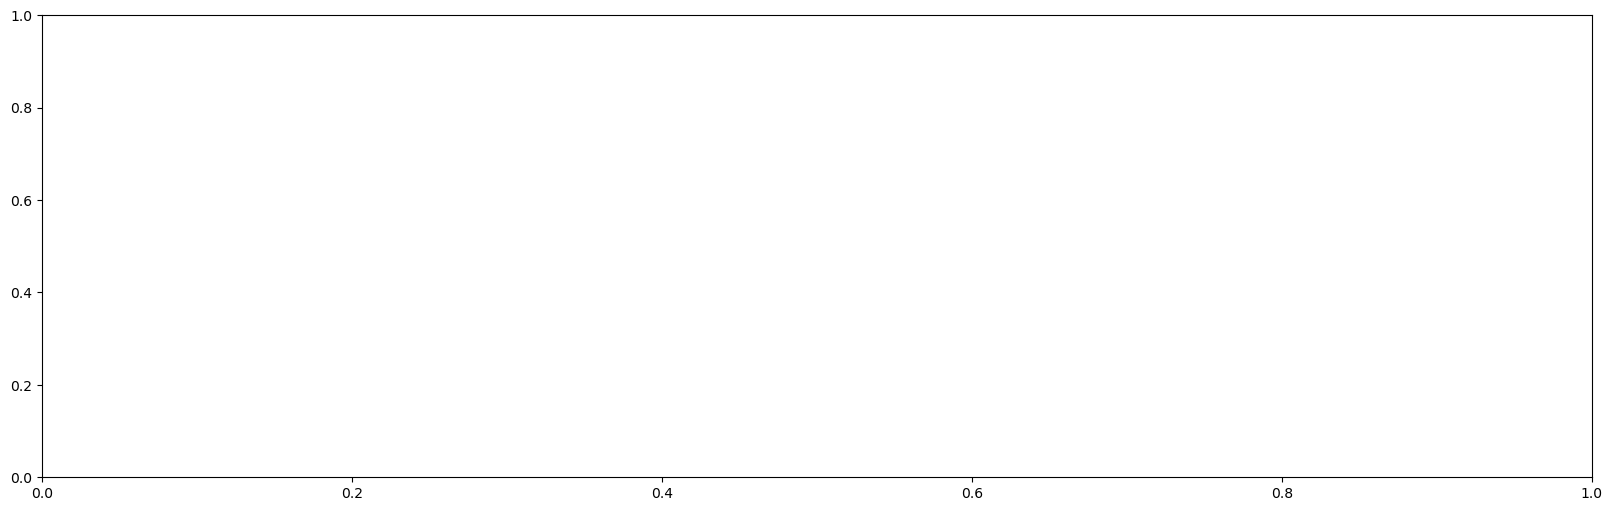

In [20]:
def animate(step):
    simulator.simulation_step(density, truck_fraction, arrival_rate, a_dec)  # Run a simulation step
    ax.clear()  # Clear the previous plot
    ax.imshow(simulator.road.road_occupancy.T, cmap='gray_r', origin='lower')
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Road Length')
    ax.set_ylabel('Lane')
    ax.set_xticks(range(0, simulator.road.road_length + 1, 1))
    ax.set_yticks(range(0, simulator.road.road_width + 1, 1))
    ax.grid(True)

# Initialize road and simulator
road = Road(road_length=50, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1
truck_fraction = 0.1
arrival_rate = 0.05
a_dec = 2

simulator.initialize_vehicles(density, truck_fraction, 0.2, 0)  # Initialize vehicles

# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(20, 6))

# Create the animation
anim = FuncAnimation(fig, animate, frames=50, interval=100)

# Save the animation as a GIF or MP4
anim.save('road_simulation2.gif', writer='pillow')
# Or save as MP4
# anim.save('road_simulation.mp4', writer='ffmpeg')

# Show the animation in a Jupyter notebook (if using one)
plt.show()

This portion is another part.